 # Mini-Challenge Michelle Rohrer Part 5

Wer kennt es nicht, man steht vor einer tollen Landschaftskulisse und möchte ein Foto davon machen. Das Problem ist jedoch, dass die Panoramafunktion oftmals nicht gut funktioniert und die Schnittstellen sind nicht sauber. Ich hatte in Frankreich auf meiner Reise das gleiche problem und möchte nun mit Hilfe von Eckendetektion mehrere Fotos zu einem Panoramabild machen.

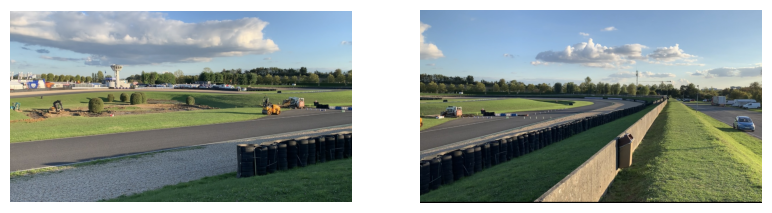

In [1]:
# Bilder einfügen
from PIL import Image
import matplotlib.pyplot as plt

image_1 = Image.open("IMG_1592.jpg")
image_2 = Image.open("IMG_1593.jpg")

# Bilder anzeigen
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(image_2)
plt.axis('off')
plt.subplot(1, 3, 2)

plt.imshow(image_1)
plt.axis('off')
plt.show()

Ich werde mit der Bildstitching Methode die beiden Bilder vergleichen und sie an den Seiten zusammenführen. 
Beim Stitching-Prozess geht es darum, markante Schlüsselpunkte in den überlappenden Bereichen der Bilder zu finden, diese miteinander zu vergleichen und dann die Bilder so zu transformieren, dass sie korrekt ausgerichtet werden. Diese Schlüsselpunkte können Ecken, Kanten oder andere auffällige Bildbereiche sein, die leicht erkennbar und robust gegenüber Skalierung oder Perspektivwechsel sind.
(Der Text wurde mit ChatGPT generiert)

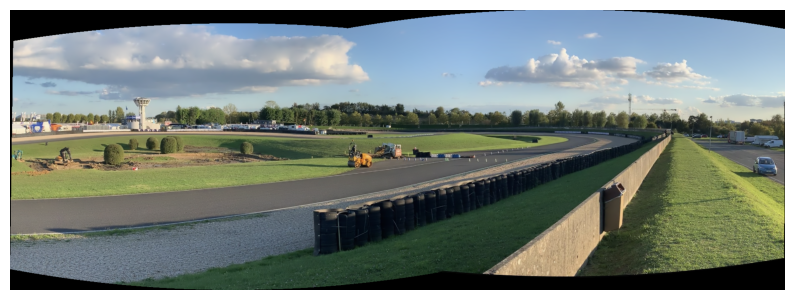

In [2]:
import cv2
import numpy as np

# Konvertiere die PIL-Bilder in ein OpenCV-kompatibles Format (Numpy-Array)
image_1_cv = cv2.cvtColor(np.array(image_1), cv2.COLOR_RGB2BGR)
image_2_cv = cv2.cvtColor(np.array(image_2), cv2.COLOR_RGB2BGR)

# Erstelle eine Liste der Bilder
images = [image_1_cv, image_2_cv]

# Erstelle das Stitcher-Objekt
stitcher = cv2.Stitcher_create()

# Führe den Stitching-Prozess durch
status, panorama = stitcher.stitch(images)

# Bild anzeigen
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# Änderung

## Vorgang

1. Bildvorverarbeitung
- das Bild muss von RGB in ein BGR umgewandelt werden, da CV2 mit BGR arbeitet und somit die Farbe richtig dargestellt wird

2. Erstellung des Stitcher-Objektes
- das Stitcher-Objekt kombiniert mehrere Bilder, die sich in ihrem Sichtfeld (Ecken, Kanten) überlappen zu einem Bild

3. Stitching-Prozess
- Im Stitching-Prozess identifiziert der Algorithmus markante Punkte, Ecken und Kanten im Bild, die charakteristisch und leicht wiederzuerkennen sind. Diese Merkmale sind entscheidend, da sie als Referenzpunkte zur Bildausrichtung dienen. 

- Eckenerkennung: Ecken sind Bildpunkte, an denen sich die Helligkeit des Bildes in verschiedene Richtungen stark verändert. Sie sind oft an Stellen zu finden, wo Linien oder Formen aufeinandertreffen, z. B. an Gebäudeecken oder Texturen. Ecken haben den Vorteil, dass sie unabhängig von Perspektiv- und Beleuchtungsveränderungen bestehen bleiben, was sie zu besonders verlässlichen Referenzpunkten macht.

- Kanten und andere Merkmale: Neben Ecken identifiziert der Algorithmus auch Kanten und andere charakteristische Merkmale im Bild. Eine Kante ist eine Linie oder ein Übergangsbereich, wo sich die Helligkeit schrittweise verändert. Sie bieten zusätzliche Orientierung, aber sind oft weniger eindeutig als Ecken, da Kanten in beiden Richtungen verlaufen und daher mehrere potenzielle Ausrichtungen haben können.

- Merkmalsabgleich (Feature Matching): Nachdem Ecken und Kanten extrahiert sind, analysiert der Algorithmus die Merkmalsbeschreibungen dieser Punkte. Durch sogenannte Deskriptoren (Zahlenwerte, die die Eigenschaften eines Punktes beschreiben) kann der Algorithmus für jeden Punkt ein einzigartiges Profil erstellen. Dann werden die Merkmale der Bilder verglichen, um Übereinstimmungen zu finden. Dies geschieht oft über Methoden wie den Brute-Force-Matcher die Punktpaare mit ähnlichen Deskriptoren verknüpfen.

- Homographie-Berechnung: Sobald genügend Übereinstimmungen gefunden sind, berechnet der Algorithmus eine Transformation, die die Bilder präzise übereinanderlegt. Diese Transformation ermöglicht es, ein Bild so zu verzerren und auszurichten, dass es perfekt auf das andere passt. Hierbei sind die identifizierten Ecken besonders hilfreich, da sie als feste Ankerpunkte dienen und die Anpassung stabilisieren.

3. Bilddarstellung
- Zum Schluss wird das resultierende Panorama-Bild mit plt.imshow in einem RGB-Farbraum dargestellt, um das Ergebnis visuell zu überprüfen.

# Änderung Ende

#### Überlappung der Kanten

Den Algorithmus zum ertsellen des Panoramas habe ich bereits erstellt. Um nun besser verstehen zu können wie das Stiching funktioniert habe ich nun einen weiteren Algorithmus implementiert. Dieser zeigt an, welche Markanten Stellen das Bild hat und wo die Bilder in den Ecken/ Kanten identisch ist.

In [3]:
# Erstelle einen SIFT-Detektor
sift = cv2.SIFT_create()

# Erkenne Keypoints und berechne Deskriptoren
keypoints_1, descriptors_1 = sift.detectAndCompute(image_1_cv, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(image_2_cv, None)

# Brute-Force-Matcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_1, descriptors_2, k=2)

# Lowe's Ratio Test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

matched_image = cv2.drawMatches(image_2_cv, keypoints_2, image_1_cv, keypoints_1, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


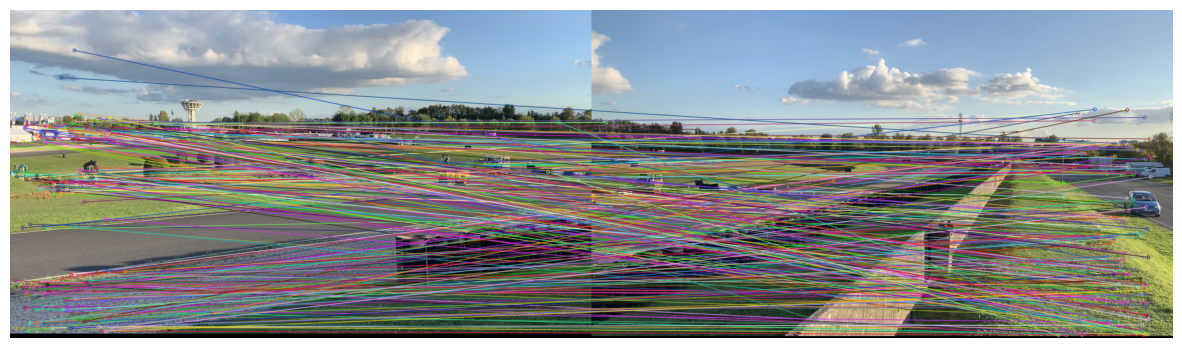

In [4]:
# Bild anzeigen
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Das Bild zeigt leider nicht den gewünschten Effekt, denn es werden nur die äusseren Stellen verglichen und nicht die inneren Stellen, welche überlappt werden sollen.

# Änderung

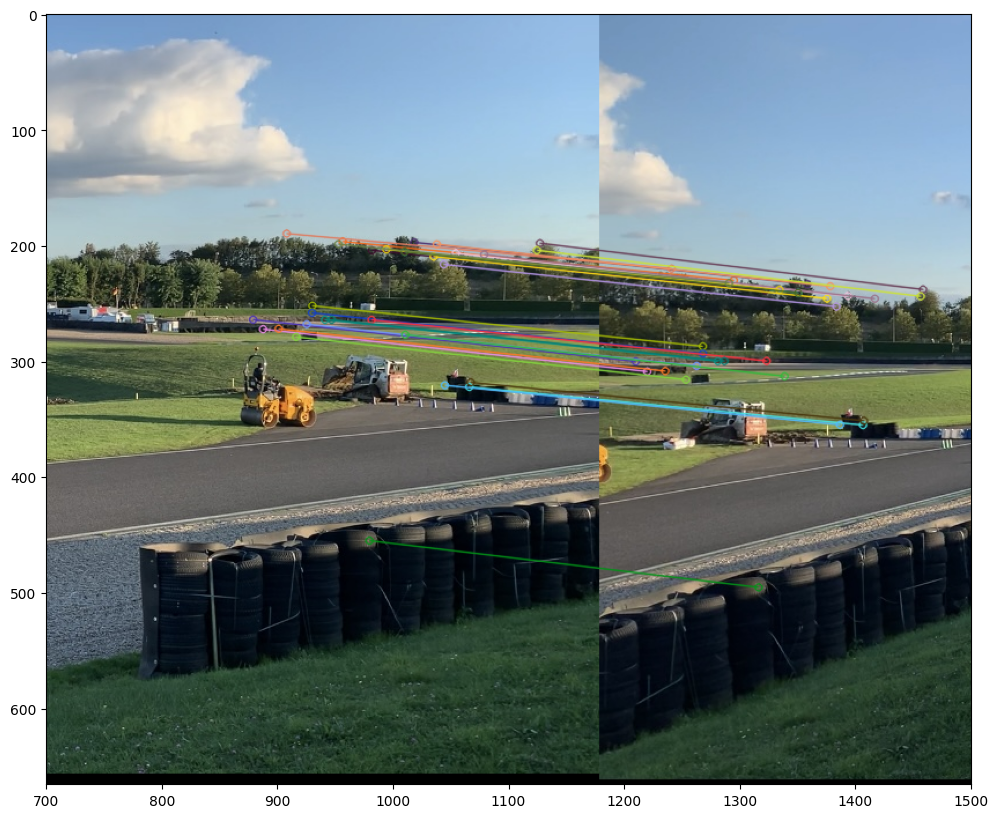

In [5]:
# SIFT-Detektor
sift = cv2.SIFT_create()

roi_width_ratio = 0.75

# Region of Interest (ROI) für jedes Bild definieren
left_image_roi = image_2_cv[:, int((1 - roi_width_ratio) * image_2_cv.shape[1]):]
right_image_roi = image_1_cv[:, :int(roi_width_ratio * image_1_cv.shape[1])]

keypoints_2, descriptors_2 = sift.detectAndCompute(left_image_roi, None)
keypoints_1, descriptors_1 = sift.detectAndCompute(right_image_roi, None)

# Brute-Force-Matcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_2, descriptors_1, k=2)

# Lowe's Ratio Test anwenden
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Sortiere die Übereinstimmungen nach Distanz
good_matches = sorted(good_matches, key=lambda x: x.distance)

# Anzahl der besten Übereinstimmungen, die angezeigt werden sollen
num_matches_to_show = 30
matches_to_draw = good_matches[:num_matches_to_show]

for kp in keypoints_2:
    kp.pt = (kp.pt[0] + int((1 - roi_width_ratio) * image_2_cv.shape[1]), kp.pt[1])
matched_image = cv2.drawMatches(image_2_cv, keypoints_2, image_1_cv, keypoints_1, matches_to_draw, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Bild anzeigen
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.xlim(700, 1500)
plt.show()


Ich habe nun den Code so angepasst, dass die richtige Seite des Bildes verlgichen werden. Nun wird auch gut sichtbar, welche markanten Stelle sich sehr ähnlich sind und wo das Bild dann zusammengefügt wird.

Das der Bagger nicht als markantes Objekt erkannt wird, trotz anpassungen der Parameter könnte merhrere Ursachen haben:

- glatte oder uniforme Oberflächen, die keine charakteristischen Merkmale aufweisen

- schlechte Beleuchtung oder starke Schatten, die die Merkmale verdecken oder verzerren

- unscharfe oder verrauschte Bilder, die die Merkmalsextraktion erschweren


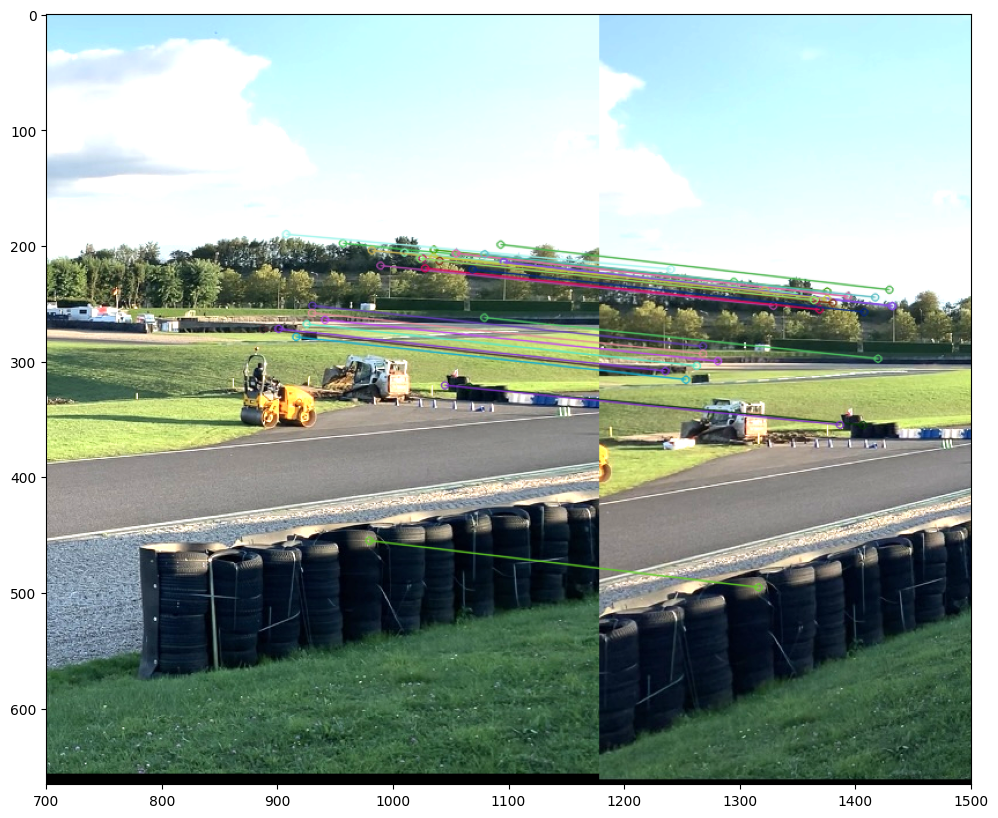

In [6]:
# Kontrast erhöhen
image_1_cv = cv2.convertScaleAbs(image_1_cv, alpha=1.5, beta=0)
image_2_cv = cv2.convertScaleAbs(image_2_cv, alpha=1.5, beta=0)

# SIFT-Detektor
sift = cv2.SIFT_create()

roi_width_ratio = 0.75

# Region of Interest (ROI) für jedes Bild definieren
left_image_roi = image_2_cv[:, int((1 - roi_width_ratio) * image_2_cv.shape[1]):]
right_image_roi = image_1_cv[:, :int(roi_width_ratio * image_1_cv.shape[1])]

keypoints_2, descriptors_2 = sift.detectAndCompute(left_image_roi, None)
keypoints_1, descriptors_1 = sift.detectAndCompute(right_image_roi, None)

# Brute-Force-Matcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_2, descriptors_1, k=2)

# Lowe's Ratio Test anwenden
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Sortiere die Übereinstimmungen nach Distanz
good_matches = sorted(good_matches, key=lambda x: x.distance)

# Anzahl der besten Übereinstimmungen, die angezeigt werden sollen
num_matches_to_show = 30
matches_to_draw = good_matches[:num_matches_to_show]

for kp in keypoints_2:
    kp.pt = (kp.pt[0] + int((1 - roi_width_ratio) * image_2_cv.shape[1]), kp.pt[1])
matched_image = cv2.drawMatches(image_2_cv, keypoints_2, image_1_cv, keypoints_1, matches_to_draw, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Bild anzeigen
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
plt.xlim(700, 1500)
plt.show()

Hier wird der Bagger auch nicht erkannt, vermutlich weil der Kontrast zu dem Gras zu gering ist und das der Bagger zu unscharf ist.

Ich werde die Kanten nochmals genauer Untersuchen mit verschiedenen Methoden:

1. Sobel Edge Detection eignet sich gut, um grundlegende Kanten zu identifizieren, aber es ist empfindlicher gegenüber Rauschen.

2. Canny Edge Detection ist präziser und robust gegenüber kleineren Details, bietet aber ein klareres Kantenbild.

3. Threshold Image liefert eine grobe Trennung von hellen und dunklen Bereichen, hilft jedoch nicht direkt bei der Kantenanalyse.

4. Canny after Gaussian Blur liefert die klarsten und stabilsten Kanten und ist somit am besten geeignet, wenn die Kantenerkennung bei gleichzeitiger Rauschunterdrückung priorisiert wird.

In [9]:
# Schritt 2: In Graustufen umwandeln
gray_image = cv2.cvtColor(image_1_cv, cv2.COLOR_BGR2GRAY)

# Schritt 3: Kantendetektion mit Sobel- und Canny-Filter
# Sobel-Filter
sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)  # Kantenerkennung in X-Richtung
sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)  # Kantenerkennung in Y-Richtung
sobel_combined = cv2.magnitude(sobel_x, sobel_y)  # Kombiniere beide Richtungen

# Canny-Edge-Detektor
canny_edges = cv2.Canny(gray_image, threshold1=50, threshold2=150)

# Schritt 4: Schwellwert setzen
_, threshold_image = cv2.threshold(gray_image, 120, 255, cv2.THRESH_BINARY)

# Schritt 5: Bild skalieren (Optional, hier zeigen wir nur den Originalmaßstab)

# Schritt 6: Gaussian Blur + Canny-Edge-Detektion
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
canny_blurred_edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)

# Ergebnisse anzeigen
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(cv2.cvtColor(image_1_cv, cv2.COLOR_BGR2RGB))  # Fix: replaced image_1 with image_1_cv
axes[0, 0].set_title("Original Image")
axes[0, 0].axis("off")

axes[0, 1].imshow(gray_image, cmap="gray")
axes[0, 1].set_title("Gray Image")
axes[0, 1].axis("off")

axes[0, 2].imshow(sobel_combined, cmap="gray")
axes[0, 2].set_title("Sobel Edge Detection")
axes[0, 2].axis("off")

axes[1, 0].imshow(canny_edges, cmap="gray")
axes[1, 0].set_title("Canny Edge Detection")
axes[1, 0].axis("off")

axes[1, 1].imshow(threshold_image, cmap="gray")
axes[1, 1].set_title("Threshold Image")
axes[1, 1].axis("off")

axes[1, 2].imshow(canny_blurred_edges, cmap="gray")
axes[1, 2].set_title("Canny after Gaussian Blur")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()


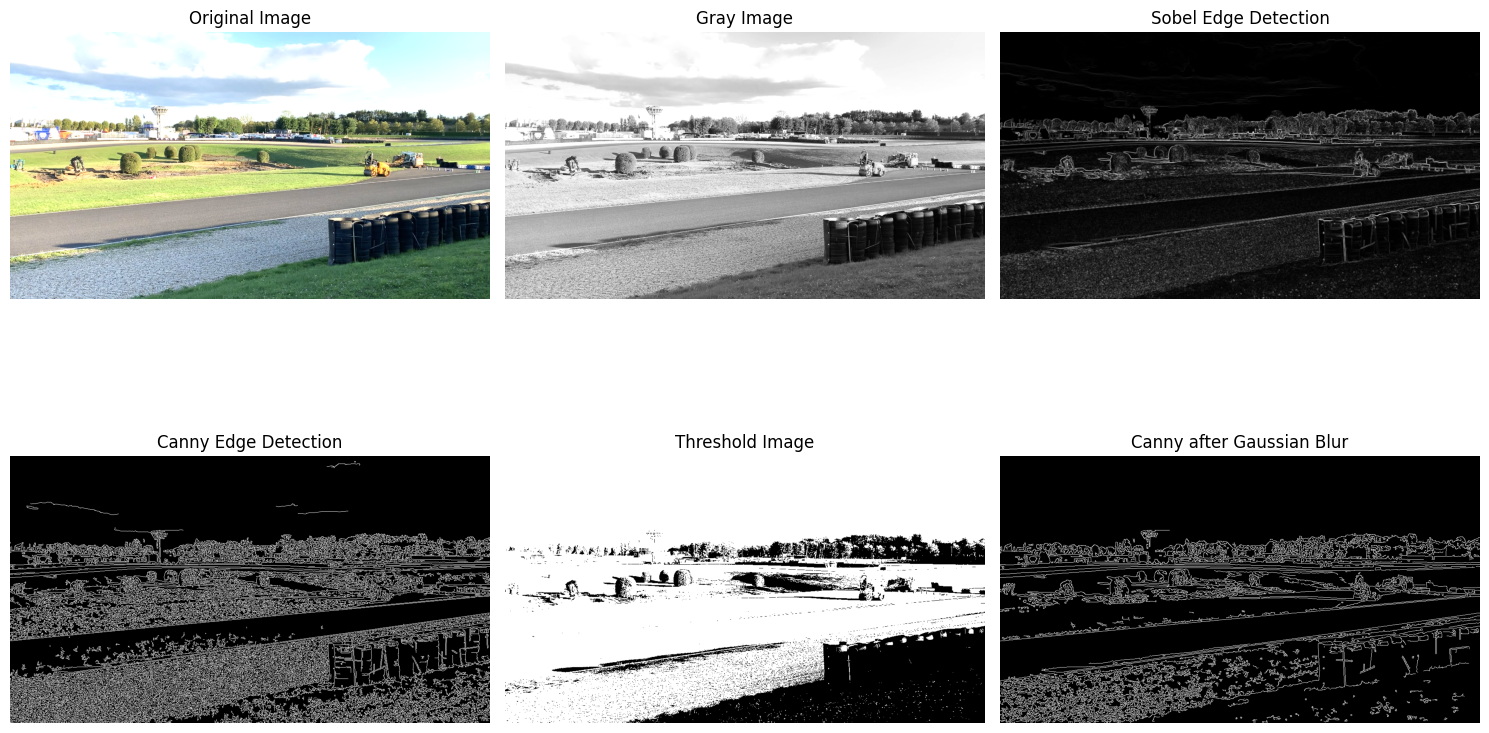

In [10]:
# Schritt 2: In Graustufen umwandeln
gray_image = cv2.cvtColor(image_2_cv, cv2.COLOR_BGR2GRAY)

# Schritt 3: Kantendetektion mit Sobel- und Canny-Filter
# Sobel-Filter
sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)  # Kantenerkennung in X-Richtung
sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)  # Kantenerkennung in Y-Richtung
sobel_combined = cv2.magnitude(sobel_x, sobel_y)  # Kombiniere beide Richtungen

# Canny-Edge-Detektor
canny_edges = cv2.Canny(gray_image, threshold1=50, threshold2=150)

# Schritt 4: Schwellwert setzen
_, threshold_image = cv2.threshold(gray_image, 120, 255, cv2.THRESH_BINARY)

# Schritt 5: Bild skalieren (Optional, hier zeigen wir nur den Originalmaßstab)

# Schritt 6: Gaussian Blur + Canny-Edge-Detektion
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
canny_blurred_edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)

# Ergebnisse anzeigen
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(cv2.cvtColor(image_2_cv, cv2.COLOR_BGR2RGB))  # Fix: replaced image_1 with image_1_cv
axes[0, 0].set_title("Original Image")
axes[0, 0].axis("off")

axes[0, 1].imshow(gray_image, cmap="gray")
axes[0, 1].set_title("Gray Image")
axes[0, 1].axis("off")

axes[0, 2].imshow(sobel_combined, cmap="gray")
axes[0, 2].set_title("Sobel Edge Detection")
axes[0, 2].axis("off")

axes[1, 0].imshow(canny_edges, cmap="gray")
axes[1, 0].set_title("Canny Edge Detection")
axes[1, 0].axis("off")

axes[1, 1].imshow(threshold_image, cmap="gray")
axes[1, 1].set_title("Threshold Image")
axes[1, 1].axis("off")

axes[1, 2].imshow(canny_blurred_edges, cmap="gray")
axes[1, 2].set_title("Canny after Gaussian Blur")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()


Man erkennt hier sehr gut in beiden Bildern, dass der Bagger als Kantenerkennung nicht besonders gut erkannt wird. Andere Stellen, wie der Reifenstapel und die Strukturen der Bäume sind jedoch besser erkennbar als markante Stellen.

Als nächsten Schritt möchte ich den Übergang der Bilder genauer anschauen.

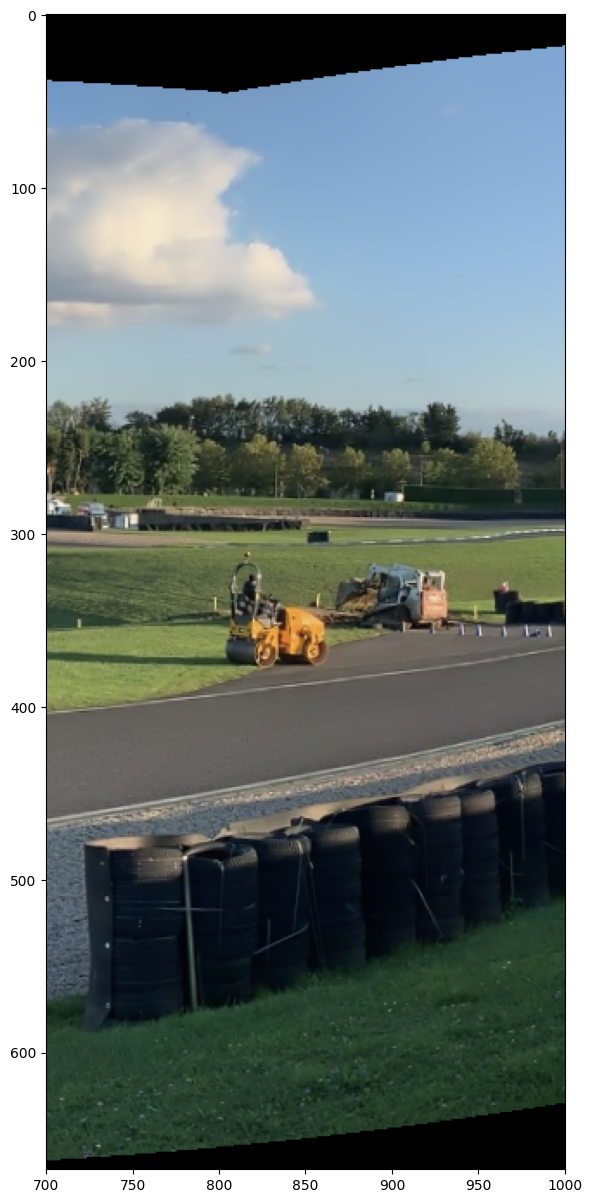

In [7]:
# panorama übergang anzeigen
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.xlim(700, 1000)
plt.show()

Die markanten Ecken wurden sehr gut erkannt von meinem Algortihmus detektiert und man erkennt keinen Übergang im Panorama. Leider hat man bei dem Bild eine ziemliche Rotation, was dazu führt, dass es oben und unten dunkle Stellen gibt. Ich könnte das Bild zuschneiden, sodass sie dann nicht mehr sichtbar sind, leider wird dann aber sehr viel vom Bild abgeschnitten. 

#### Tag 28 Schlussbewertung

Mein Ziel ein Panorama zu erstellen aus zwei Bildern hat sehr gut funktioniert. Ich habe zuerst einen Algorithmus erstellt, welches ein Stiching-Prozess durchführt. Die Bilder werden also durch "nähen" zusammengefügt ohne sichtbare Punkte. Dabei wertden markante Stellen gesucht, welche bei beiden Bildern gleich sind und die Bilder werden dementsprechend rotiert und an der richtigen Stelle zusammengefügt. 

Die weitere Analyse der Ecken hat leider nicht so gut funktioniert und war sehr aufwändig, also habe ich nur die besten 30 Übereinstimmungspunkte analysiert, um darzustellen wo die Bilder dann überlappt werden. Ich habe dann noch versucht, weitere Methoden zu implementieren, welche die Ecken und Kanten besser beschreiben, um die Übereinstimmungspunkte besser zu verstehen.

Ich habe dann noch versucht das Panorama zu vervollständigen, leider hat der Algorithmus es nicht geschafft die anderen Bilder dran zu "nähen", da sie zu wenig übereinstimmungen haben. Generell war es für mich ein sehr schweres Thema zum erarbeiten, dies war mir nicht bewusst bei der Wahl des Themas. Ich bin jedoch sehr zufrieden, konnte ich den Algorithmus für diese zwei Bilder zum laufen bringen und somit statt einem Video ein schönes Erinnerungsfoto von meinem Frankreichurlaub schaffen.

# Änderung Ende